# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries

!pip install keras_tuner

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner.tuners import GridSearch, RandomSearch

# from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings(action='ignore')

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
from google.colab import drive
drive.mount("/content/drive/")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Define a function to load data and aggregate them



def get_data_from_csv_files(fnames, base_path):
  agg_df = pd.DataFrame()
  stocks = list()
  for fname in fnames:
    df = pd.read_csv(base_path+fname)
    agg_df = pd.concat([agg_df, df], axis=0)
    stocks.append(df)

  return agg_df, stocks


In [4]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

base_path = '/content/drive/MyDrive/AIML_DataFiles_Storage/RNN/Assignment/'
fnames = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']

stocks_df, stocks = get_data_from_csv_files(fnames=fnames, base_path=base_path)
stocks_df.reset_index(inplace=True, drop=True)

target_classes = set(stocks_df['Name'])
target_classes

{'AMZN', 'GOOGL', 'IBM', 'MSFT'}

In [5]:
# View specifics of the data

stocks_df.head()

Date   Open   High    Low  Close   Volume  Name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN

In [6]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB


In [7]:
lbl_encoder = LabelEncoder()

stocks_df['Date'] = pd.to_datetime(stocks_df['Date'], errors='coerce')
stocks_df['CompanyName'] = lbl_encoder.fit_transform(stocks_df['Name'])

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [8]:
# Handle Missing Values

stocks_df.isna().mean(), stocks_df.isna().sum()

(Date           0.000000
 Open           0.000083
 High           0.000000
 Low            0.000083
 Close          0.000000
 Volume         0.000000
 Name           0.000000
 CompanyName    0.000000
 dtype: float64,
 Date           0
 Open           1
 High           0
 Low            1
 Close          0
 Volume         0
 Name           0
 CompanyName    0
 dtype: int64)

In [9]:
stocks_df[stocks_df['Low'].isna()]

Date  Open    High  Low   Close   Volume Name  CompanyName
8951 2017-07-31   NaN  144.93  NaN  144.67  4355718  IBM            2

In [10]:
# stocks_df[(stocks_df['Date'] == '2017-07-31') & (stocks_df['Name']=='IBM')]

In [11]:
# stocks_df = stocks_df[~(stocks_df['Low'].isna())]
stocks_df = stocks_df.dropna()

In [12]:
def get_date_vals(attr, col):
  vals = getattr(stocks_df[col].dt, attr)
  return vals

def get_date_method_vals(attr, col):
  vals = getattr(stocks_df[col].dt, attr)()
  return vals

date_lbl_encoder = LabelEncoder()

def extract_date_vals(df):
  df['Day'] = get_date_vals('day', 'Date')
  df['Month'] = get_date_vals('month', 'Date')
  df['Year'] = get_date_vals('year', 'Date')
  df['Day_Name'] = get_date_method_vals('day_name', 'Date')
  df['Day_Number'] = date_lbl_encoder.fit_transform(df['Day_Name'])

extract_date_vals(stocks_df)



In [13]:
stocks_df.tail(12077)

Date   Open   High    Low  Close    Volume  Name  CompanyName  \
0     2006-01-03  47.47  47.85  46.25  47.58   7582127  AMZN            0   
1     2006-01-04  47.48  47.73  46.69  47.25   7440914  AMZN            0   
2     2006-01-05  47.16  48.20  47.11  47.65   5417258  AMZN            0   
3     2006-01-06  47.97  48.58  47.32  47.87   6154285  AMZN            0   
4     2006-01-09  46.55  47.10  46.40  47.08   8945056  AMZN            0   
...          ...    ...    ...    ...    ...       ...   ...          ...   
12072 2017-12-22  85.40  85.63  84.92  85.51  14145841  MSFT            3   
12073 2017-12-26  85.31  85.53  85.03  85.40   9891237  MSFT            3   
12074 2017-12-27  85.65  85.98  85.22  85.71  14678025  MSFT            3   
12075 2017-12-28  85.90  85.93  85.55  85.72  10594344  MSFT            3   
12076 2017-12-29  85.63  86.05  85.50  85.54  18717406  MSFT            3   

       Day  Month  Year   Day_Name  Day_Number  
0        3      1  2006    Tuesday           3  
1        4      1  2006  Wednesday           4  
2        5      1  2006   Thursday           2  
3        6      1  2006     Friday           0  
4        9      1  2006     Monday           1  
...    ...    ...   ...        ...         ...  
12072   22     12  2017     Friday           0  
12073   26     12  2017    Tuesday           3  
12074   27     12  2017  Wednesday           4  
12075   28     12  2017   Thursday           2  
12076   29     12  2017     Friday           0  

[12076 rows x 13 columns]

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

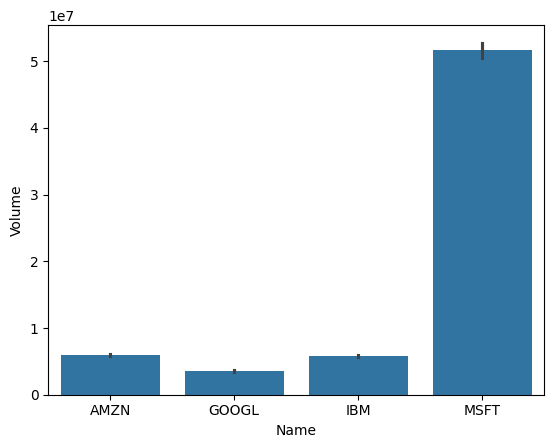

In [14]:
# Frequency distribution of volumes

sns.barplot(data=stocks_df, x='Name', y='Volume')
plt.show()

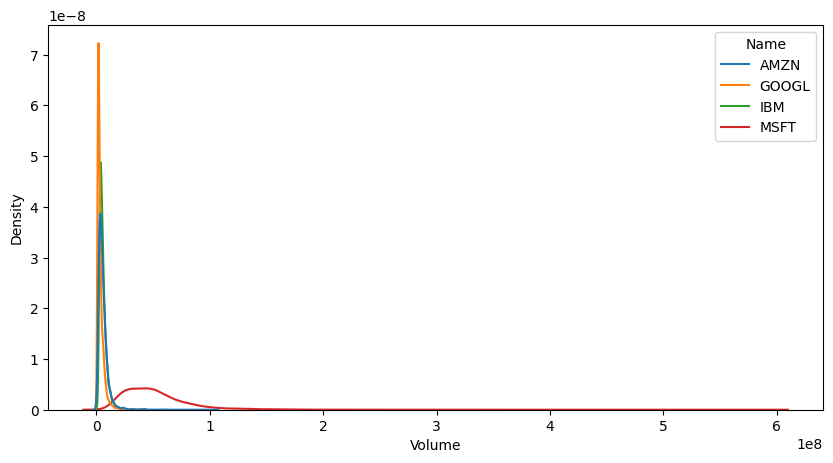

In [15]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=stocks_df, x='Volume', hue='Name')
plt.show()

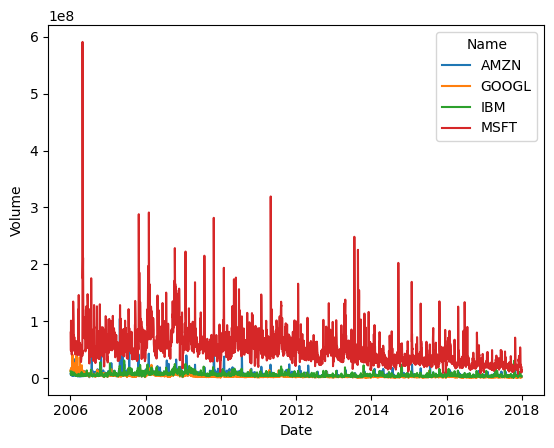

In [16]:
# Stock volume variation over time

sns.lineplot(stocks_df, x='Date', y='Volume', hue='Name')
plt.show()

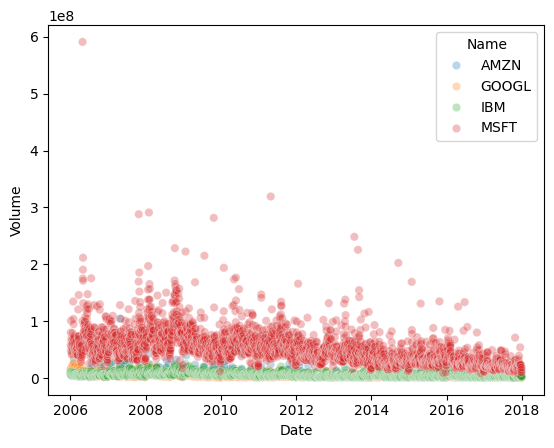

In [17]:
sns.scatterplot(stocks_df, x='Date', y='Volume', hue='Name', alpha=0.3)
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

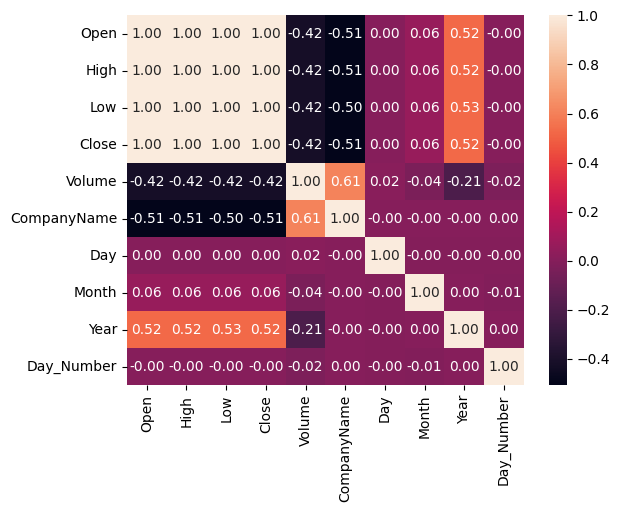

In [18]:
# Analyse correlations

num_df = stocks_df.select_dtypes(include='number')
sns.heatmap(num_df.corr(), fmt='0.2f', annot=True)
plt.show()

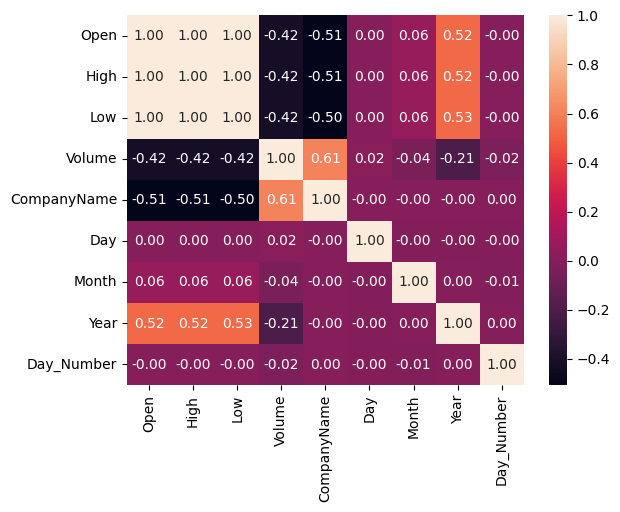

In [19]:

num_df = stocks_df.select_dtypes(include='number')
num_df = num_df.drop('Close', axis=1)
sns.heatmap(num_df.corr(), fmt='0.2f', annot=True)
plt.show()

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [20]:
# Define a function that divides the data into windows and generates target variable values for each window




def generate_timesteps(df, window_size, step_size):
  X = []
  y = []

  extract_date_vals(df)
  df = df.dropna()

  # for cls in sorted(target_classes):
  #   data['Comp_'+cls] = (df['Name']==cls).astype(int)

  df['CompanyID'] = lbl_encoder.transform(df['Name'])

  data = df.select_dtypes(include='number')

  data = data.drop(['Close'], axis=1).values

  target = df['Close'].values

  for i in range(0, len(df) - window_size, step_size):
    X.append(data[i: i + window_size])
    y.append(target[i + window_size])

  X = np.array(X)
  y = np.array(y)
  return X, y

# for df in stocks:
#   X, y = generate_timesteps(df, 7, 2)
#   X, y = np.array(X), np.array(y)
#   print(X.shape)
#   break





#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [21]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows


X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()


def scale_data(data, target, is_trainable=True):
  x_scaled = []
  y_scaled = []

  for x_win, y in zip(data, target):
    y = np.array(y).reshape(-1, 1)
    if is_trainable:
      X_scaler.partial_fit(x_win)
      y_scaler.partial_fit(y)

    x_scaled.append(X_scaler.transform(x_win))
    y_scaled.append(y_scaler.transform(y))

  x_scaled = np.array(x_scaled)
  y_scaled = np.array(y_scaled).reshape(-1, 1)
  return x_scaled, y_scaled



Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [22]:
# Define a function to create input and output data points from the master DataFrame


def split_data(data, target, test_size):
  split_index = int(len(data) * (1 - test_size))

  X_train, X_test = data[:split_index], data[split_index:]
  y_train, y_test = target[:split_index], target[split_index:]


  X_train_scaled, y_train_scaled = scale_data(X_train, y_train, is_trainable=True)
  X_test_scaled, y_test_scaled = scale_data(X_test, y_test, is_trainable=False)

  return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled


def get_companies(target_class):
  if isinstance(target_class, str):
    target_class = [target_class]

  return [df[df['Name'].isin(target_class)] for df in stocks if df['Name'].isin(target_class).any()]

def prepare_data(stocks, target_class, window_size, window_stride, test_size):
  '''
  target_class: 'str' or 'list'
  '''
  X, y = [], []

  target_stocks = get_companies(target_class)

  for df in target_stocks:
    data, target = generate_timesteps(df=df, window_size=window_size, step_size=window_stride)
    X.append(data)
    y.append(target)

  X = np.concatenate(X, axis=0)
  y = np.concatenate(y, axis=0)
  return split_data(X, y, test_size=test_size)



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

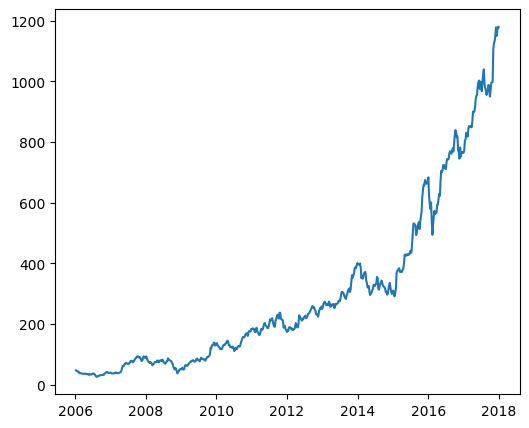

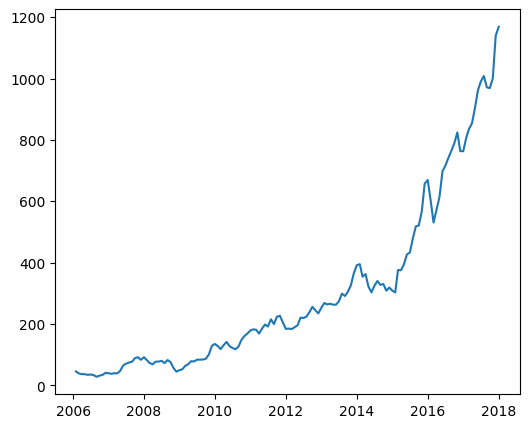

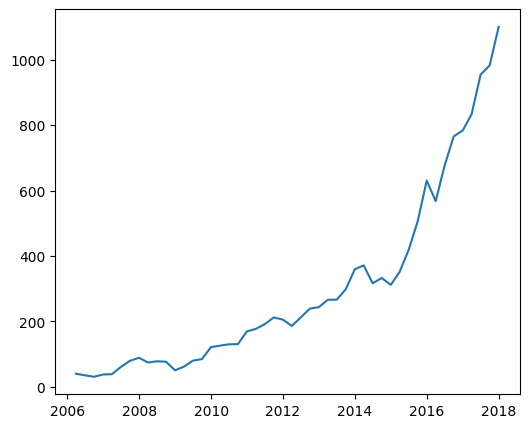

In [23]:
# Checking for patterns in different sequence lengths


def plot_trends(time_line, company_name):

  '''
  time_line: 'str' ('W', 'M', 'Q')
  '''

  df = get_companies(company_name)[0].copy()

  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)
  plt.figure(figsize=(6, 5))
  plt.plot(df['Close'].resample(time_line).mean())
  plt.show()


plot_trends('W', 'AMZN')
plot_trends('M', 'AMZN')
plot_trends('Q', 'AMZN')

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [24]:
# Create data instances from the master data frame using decided window size and window stride

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = prepare_data(stocks, 'AMZN', 7, 2, 0.2)


In [25]:
# Check the number of data points generated
print('Datapoints generated')
print(f'Training data points features: {len(X_train_scaled)}, target:{len(y_train_scaled)}')
print(f'Testing data points features: {len(X_test_scaled)}, target:{len(y_test_scaled)}')
print(f'Total data points: {len(X_train_scaled) + len(X_test_scaled)}')

Datapoints generated
Training data points features: 1204, target:1204
Testing data points features: 302, target:302
Total data points: 1506


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [26]:
# Check if the datasets are compatible inputs to neural networks

print('Shape of samples')
print(f'X_train_scaled: {X_train_scaled.shape}, y_train_scaled: {y_train_scaled.shape}')
print(f'X_test_scaled: {X_test_scaled.shape}, y_test_scaled: {y_test_scaled.shape}')

Shape of samples
X_train_scaled: (1204, 7, 9), y_train_scaled: (1204, 1)
X_test_scaled: (302, 7, 9), y_test_scaled: (302, 1)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [27]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_simple_rnn(hp):
  model = Sequential()
  model.add(Input(shape=X_train_scaled.shape[1:]))
  model.add(SimpleRNN(units=hp.Choice('units', [32, 64, 128]),
                      dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1),
                      recurrent_dropout=hp.Float('rec_dropout', min_value=0.0, max_value=0.2, step=0.1)))


  model.add(Dense(32, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1))

  lr = hp.Choice('learning_rate', [0.01, 0.001, 0.0001])
  opt = hp.Choice('optimizer', ['adam', 'sgd'])



  model.compile(
      optimizer=opt,
      loss='mse',
      metrics=['mae']
  )

  return model

def compute_metrics(y_true, y_pred):
  from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

  mse = mean_squared_error(y_true, y_pred)
  rmse = mse ** 0.5
  mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f"RMSE: {rmse:.4f}")
  print(f"MAE: {mae:.4f}")
  print(f"MAPE: {mape:.2%}")
  print(f"R² Score: {r2:.4f}")


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [28]:
# Find an optimal configuration of simple RNN


def restart_tuner(gru=False):
  import shutil
  import os

  path = 'tuner_dir/gru' if gru else 'tuner_dir/simple_rnn'
  if os.path.exists(path=path):
      shutil.rmtree(path=path)

restart_tuner()

tuner = RandomSearch(
    hypermodel=build_simple_rnn,
    max_trials=25,
    objective='val_loss',
    directory='tuner_dir',
    executions_per_trial=2,
    project_name='simple_rnn'
)

tuner.search_space_summary()

tuner.search(X_train_scaled,
             y_train_scaled,
             batch_size=32,
             epochs=10,
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=5)])


Trial 25 Complete [00h 00m 15s]
val_loss: 0.012833775486797094

Best val_loss So Far: 0.005045503610745072
Total elapsed time: 00h 08m 00s


In [29]:
# Find the best configuration based on evaluation metrics

best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best RNN units:", best_params.get('units'))
print("Best dropout:", best_params.get('dropout'))
print("Best dense units:", best_params.get('rec_dropout'))
print("Best learning rate:", best_params.get('learning_rate'))
print("Best optimizer:", best_params.get('optimizer'))

Best RNN units: 128
Best dropout: 0.0
Best dense units: 0.1
Best learning rate: 0.001
Best optimizer: sgd


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [30]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model


model = tuner.get_best_models(num_models=1)[0]
history = model.fit(X_train_scaled,
          y_train_scaled,
          batch_size=32,
          epochs=10,
          validation_split=0.20,
          callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0339 - mae: 0.1398 - val_loss: 0.0098 - val_mae: 0.0842
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0347 - mae: 0.1415 - val_loss: 0.0190 - val_mae: 0.1236
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0294 - mae: 0.1353 - val_loss: 0.0283 - val_mae: 0.1622
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0269 - mae: 0.1238 - val_loss: 0.0200 - val_mae: 0.1329
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0256 - mae: 0.1231 - val_loss: 0.0787 - val_mae: 0.2773
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0279 - mae: 0.1273 - val_loss: 0.0507 - val_mae: 0.2170



Plotting the actual vs predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0282 - mae: 0.1316
0.05974264442920685 0.19023212790489197


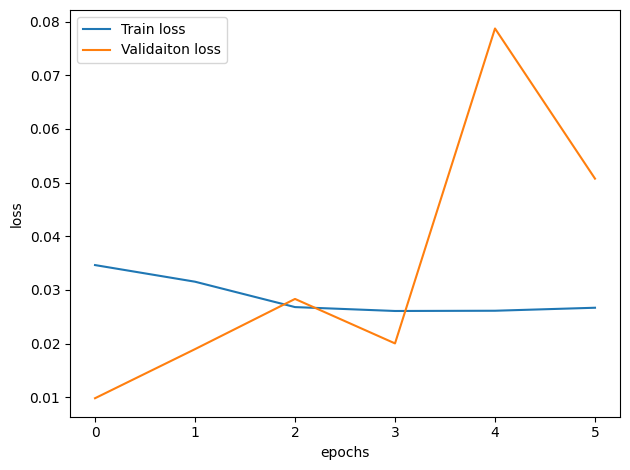

In [31]:
# Predict on the test data and plot

loss, metrics = model.evaluate(X_test_scaled, y_test_scaled, batch_size=32)
print(loss, metrics)

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validaiton loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


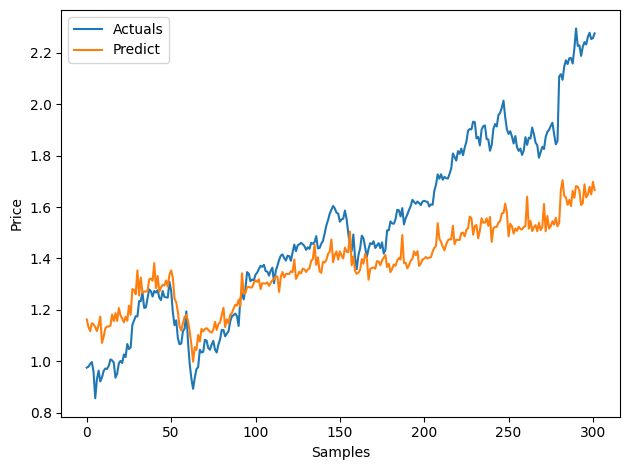

In [32]:
# Compute the performance of the model on the testing data set

y_test_pred = model.predict(x=X_test_scaled, batch_size=32, callbacks=[EarlyStopping(patience=5)])

plt.plot(y_test_scaled, label='Actuals')
plt.plot(y_test_pred, label='Predict')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
compute_metrics(y_test_scaled, y_test_pred)

RMSE: 0.2444
MAE: 0.1902
MAPE: 11.64%
R² Score: 0.5205


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [34]:
# # Define a function to create a model and specify default values for hyperparameters


def build_gru(hp):
  model = Sequential()
  model.add(Input(shape=X_train_scaled.shape[1:]))
  model.add(GRU(units=hp.Choice('units', [32, 64, 128, 256]),
                      dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1),
                      recurrent_dropout=hp.Float('rec_dropout', min_value=0.0, max_value=0.2, step=0.1)))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1))

  lr = hp.Choice('learning_rate', [0.01, 0.001, 0.0001])
  opt = hp.Choice('optimizer', ['adam', 'sgd'])



  model.compile(
      optimizer=opt,
      loss='mse',
      metrics=['mae']
  )

  return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [35]:
# Find an optimal configuration

restart_tuner(gru=True)

tuner = RandomSearch(
    hypermodel=build_gru,
    max_trials=25,
    objective='val_loss',
    directory='tuner_dir',
    executions_per_trial=2,
    project_name='gru'
)

tuner.search_space_summary()

tuner.search(X_train_scaled,
             y_train_scaled,
             batch_size=32,
             epochs=10,
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=5)])



Trial 25 Complete [00h 00m 33s]
val_loss: 0.00816427357494831

Best val_loss So Far: 0.0005897706723771989
Total elapsed time: 00h 11m 00s


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [36]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model


model = tuner.get_best_models(num_models=1)[0]
history = model.fit(X_train_scaled,
          y_train_scaled,
          batch_size=32,
          epochs=10,
          validation_split=0.20,
          callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0039 - mae: 0.0468 - val_loss: 7.2992e-04 - val_mae: 0.0195
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0027 - mae: 0.0370 - val_loss: 8.8825e-04 - val_mae: 0.0244
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0037 - mae: 0.0392 - val_loss: 6.5928e-04 - val_mae: 0.0186
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027 - mae: 0.0331 - val_loss: 5.4169e-04 - val_mae: 0.0166
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034 - mae: 0.0383 - val_loss: 0.0018 - val_mae: 0.0370
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0029 - mae: 0.0376 - val_loss: 8.5340e-04 - val_mae: 0.0217
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0036 - mae: 0.0402 - val_loss: 6.8170e-04 - val_mae: 0.0205
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0027 - mae: 0.0353 - val_loss: 0.0021 - val_mae: 0.0415
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0927
0.019763214513659477 0.1257648915052414


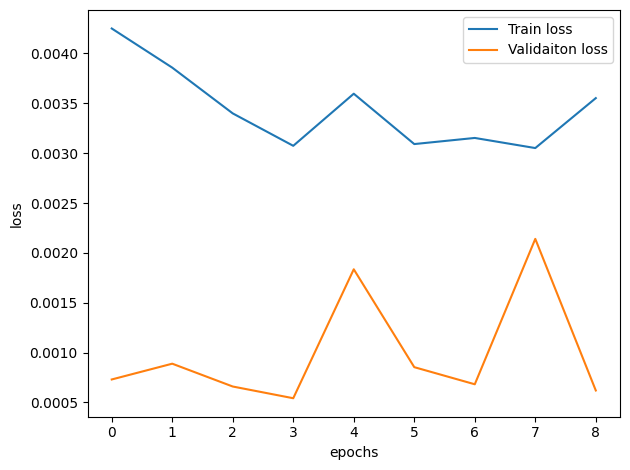

In [37]:
# Compute the performance of the model on the testing data set

loss, metrics = model.evaluate(X_test_scaled, y_test_scaled, batch_size=32)
print(loss, metrics)

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validaiton loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.show()

Plotting the actual vs predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


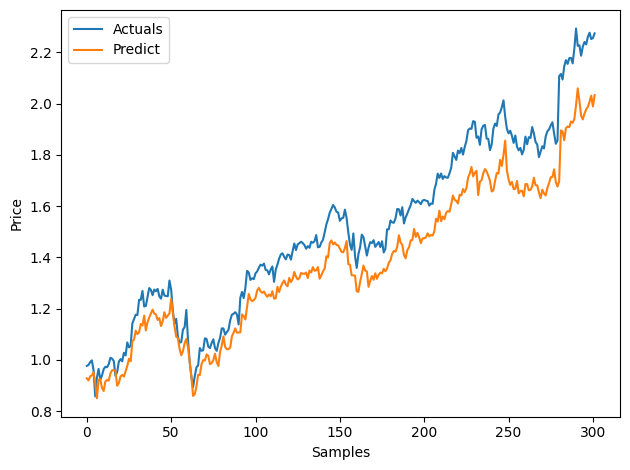

In [38]:
# Predict on the test data

y_test_pred = model.predict(x=X_test_scaled, batch_size=32, callbacks=[EarlyStopping(patience=5)])

plt.plot(y_test_scaled, label='Actuals')
plt.plot(y_test_pred, label='Predict')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
compute_metrics(y_test_scaled, y_test_pred)

RMSE: 0.1406
MAE: 0.1258
MAPE: 7.95%
R² Score: 0.8414


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [40]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = prepare_data(stocks, ['AMZN', 'GOOGL', 'IBM', 'MSFT'], 65, 5, 0.2)

In [41]:
# Check the number of data points generated

print('Datapoints generated')
print(f'Training data points features: {len(X_train_scaled)}, target:{len(y_train_scaled)}')
print(f'Testing data points features: {len(X_test_scaled)}, target:{len(y_test_scaled)}')
print(f'Total data points: {len(X_train_scaled) + len(X_test_scaled)}')

Datapoints generated
Training data points features: 1891, target:1891
Testing data points features: 473, target:473
Total data points: 2364


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN

restart_tuner()

tuner = RandomSearch(
    hypermodel=build_simple_rnn,
    max_trials=20,
    objective='val_loss',
    directory='tuner_dir',
    executions_per_trial=2,
    project_name='simple_rnn'
)

tuner.search_space_summary()

tuner.search(X_train_scaled,
             y_train_scaled,
             batch_size=32,
             epochs=10,
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=5)])

In [ ]:
# Find the best configuration


best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best RNN units:", best_params.get('units'))
print("Best dropout:", best_params.get('dropout'))
print("Best dense units:", best_params.get('rec_dropout'))
print("Best learning rate:", best_params.get('learning_rate'))
print("Best optimizer:", best_params.get('optimizer'))

In [44]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the


model = tuner.get_best_models(num_models=1)[0]
history = model.fit(X_train_scaled,
          y_train_scaled,
          batch_size=32,
          epochs=10,
          validation_split=0.20,
          callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0241 - mae: 0.1190 - val_loss: 0.1337 - val_mae: 0.3585
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0166 - mae: 0.0935 - val_loss: 0.0565 - val_mae: 0.2340
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124 - mae: 0.0784 - val_loss: 0.1371 - val_mae: 0.3674
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123 - mae: 0.0766 - val_loss: 0.0148 - val_mae: 0.1100
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - mae: 0.0729 - val_loss: 0.0060 - val_mae: 0.0670
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0723 - val_loss: 0.0071 - val_mae: 0.0682
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - mae: 0.0780 - val_loss: 0.0085 - val_mae: 0.0838
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - mae: 0.0699 - val_loss: 0.0151 - val_mae: 0.0980
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - mae

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0148 - mae: 0.1076
0.031796254217624664 0.1585484743118286


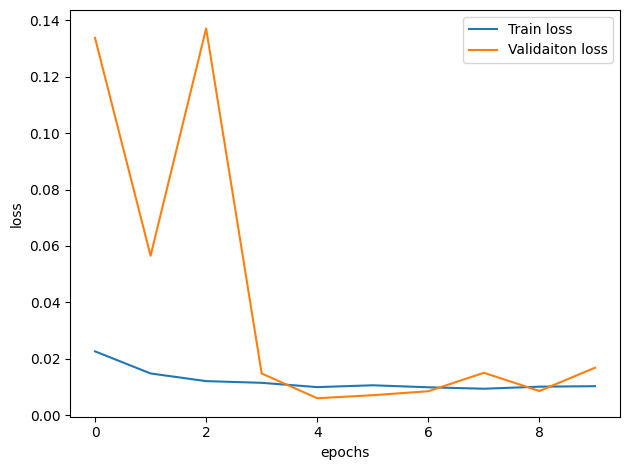

In [45]:
# Compute the performance of the model on the testing data set

loss, metrics = model.evaluate(X_test_scaled, y_test_scaled, batch_size=32)
print(loss, metrics)

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validaiton loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


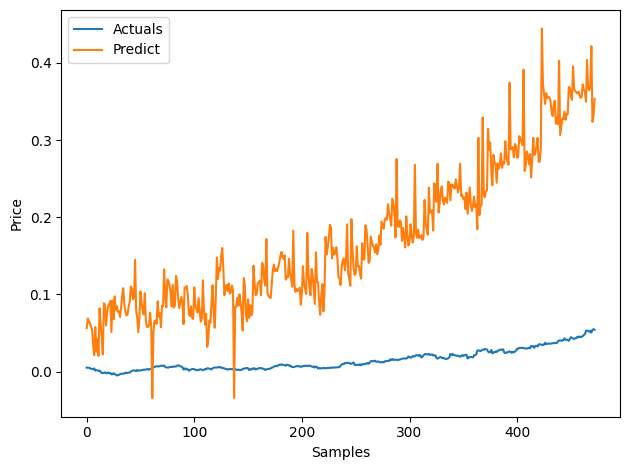

In [46]:
# Plotting the actual vs predicted values for all targets


y_test_pred = model.predict(x=X_test_scaled, batch_size=32, callbacks=[EarlyStopping(patience=5)])

plt.plot(y_test_scaled, label='Actuals')
plt.plot(y_test_pred, label='Predict')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
compute_metrics(y_test_scaled, y_test_pred)

RMSE: 0.1783
MAE: 0.1585
MAPE: 2060.56%
R² Score: -174.0606


#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [48]:
# Find an optimal configuration of advanced RNN


restart_tuner(gru=True)

tuner = RandomSearch(
    hypermodel=build_gru,
    max_trials=15,
    objective='val_loss',
    directory='tuner_dir',
    executions_per_trial=1,
    project_name='gru'
)

tuner.search_space_summary()

tuner.search(X_train_scaled,
             y_train_scaled,
             batch_size=64,
             epochs=10,
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=5)])



Trial 15 Complete [00h 01m 10s]
val_loss: 0.01607372984290123

Best val_loss So Far: 0.0007458571926690638
Total elapsed time: 00h 10m 55s


In [49]:
# Find the best configuration


best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best RNN units:", best_params.get('units'))
print("Best dropout:", best_params.get('dropout'))
print("Best dense units:", best_params.get('rec_dropout'))
print("Best learning rate:", best_params.get('learning_rate'))
print("Best optimizer:", best_params.get('optimizer'))

Best RNN units: 32
Best dropout: 0.1
Best dense units: 0.2
Best learning rate: 0.0001
Best optimizer: adam


In [50]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model

model = tuner.get_best_models(num_models=1)[0]
history = model.fit(X_train_scaled,
          y_train_scaled,
          batch_size=32,
          epochs=10,
          validation_split=0.20,
          callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0074 - mae: 0.0568 - val_loss: 0.0023 - val_mae: 0.0418
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 0.0052 - mae: 0.0485 - val_loss: 0.0041 - val_mae: 0.0554
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0054 - val_mae: 0.0612
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 0.0027 - mae: 0.0343 - val_loss: 0.0051 - val_mae: 0.0567
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - loss: 0.0028 - mae: 0.0339 - val_loss: 0.0043 - val_mae: 0.0502
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 0.0017 - mae: 0.0277 - val_loss: 0.0086 - val_mae: 0.0722


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0049 - mae: 0.0532
0.012484876438975334 0.09455806016921997


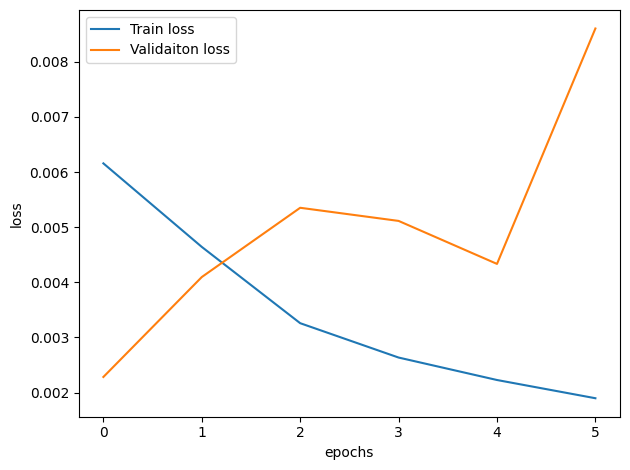

In [51]:
# Compute the performance of the model on the testing data set


loss, metrics = model.evaluate(X_test_scaled, y_test_scaled, batch_size=32)
print(loss, metrics)

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validaiton loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


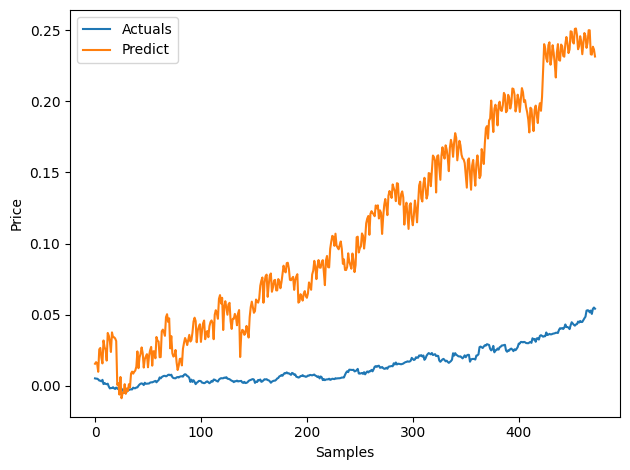

In [52]:
# Plotting the actual vs predicted values for all targets

y_test_pred = model.predict(x=X_test_scaled, batch_size=32, callbacks=[EarlyStopping(patience=5)])

plt.plot(y_test_scaled, label='Actuals')
plt.plot(y_test_pred, label='Predict')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
compute_metrics(y_test_scaled, y_test_pred)

RMSE: 0.1117
MAE: 0.0946
MAPE: 921.87%
R² Score: -67.7380


## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

**Data Processing**

1. Detected and removed 1 row with null values to ensure data integrity.
2. Merged datasets from multiple companies; observed that Microsoft has a significantly higher share volume compared to other companies, which may introduce class imbalance.
3. Identified a high correlation among Open, Close, High, and Low price features, indicating potential multicollinearity.

**Feature Engineering**
4. Initially attempted one-hot encoding for the Company Name feature, but it led to poor model performance, likely due to high dimensionality
5. Switched to **label encoding for Company Name**, which improved model performance and allowed usage with an embedding layer in the model architecture

**Model Evaluation**
<br/>
**Single Company**
6. The GRU model achieved the best performance with the highest R² score and lowest error metrics **with less training**..
7. The Simple RNN model also performed well, offering slightly higher error but still demonstrating strong predictive capability.
8. Below are the stats for single company prediction SimpleRNN and GRU

**Simple RNN for single company**
RMSE: **0.2444**
MAE: **0.1902**
MAPE: **11.64%**
R² Score: **0.5205**

**GRU for single company**
RMSE: **0.1406**
MAE: **0.1258**
MAPE: **7.95%**
R² Score: **0.8414**

**Multiple Company**
9. Simple RNN performed very poor
10. GRU models performed better then Simple RNN but poor then Single Company models.
